In [17]:
import sys

root_dir = "/home/gddaslab/mxp140/tcr_project_ultimate"
sys.path.append(root_dir)

import warnings

warnings.filterwarnings("ignore")

import h5py
import tqdm
import numpy as np
import pandas as pd
from scipy.stats import qmc
from sklearn.utils import resample
from pdf import plot_pdf, generate_configuration_per_tcr, ci_pdf, parallel_generate_configuration_per_tcr
from probability import probability
from scipy.optimize import minimize
import matplotlib.pyplot as plt
probability = np.vectorize(probability)

In [7]:
def new_neg_likelihood(
    params, fixed_x1, clone_count_values, scaled_kr_values, verbose=False
):
    # params is now just x2, fixed_x1 is provided separately
    x2 = params[0]  # params is now a 1D array with just x2
    x1 = fixed_x1
    n = len(clone_count_values)
    x1_values = np.full(n, x1)
    x2_values = np.full(n, x2)
    probs = probability(x1_values, x2_values, scaled_kr_values, clone_count_values)
    # Replace zero values with the smallest positive value allowed in Python
    smallest_positive_value = np.finfo(float).eps
    probabilities = np.where(probs == 0, smallest_positive_value, probs)
    sum_log_probs = np.sum(np.log(probabilities))
    neg_sum = -sum_log_probs

    if verbose:
        print(f"Neg-logL: {neg_sum:.8f}")
        print(f"x2: {x2:.8f}")
        print(f"=" * 80)
    return neg_sum


def run_optimization(
    clone_count_values,
    scaled_kr_values,
    fixed_x1,
    bounds=((1e-10, 100),),
    initial_guess=[5],
    verbose=False,
):
    # Modified to take fixed_x1 parameter and only optimize x2
    bounds = [bounds[0]]  # Only bounds for x2
    initial_guess = initial_guess
    result = minimize(
        new_neg_likelihood,
        initial_guess,
        args=(fixed_x1, clone_count_values, scaled_kr_values, verbose),
        method="Nelder-Mead",
        bounds=bounds,
    )

    x2 = result.x[0]
    return fixed_x1, x2, initial_guess[0], result.fun

def generate_configuration_per_tcr(prob_array, size=1):
    config_per_tcr = np.random.choice(range(1, len(prob_array)+1), size=size, replace=True, p=prob_array/sum(prob_array))
    return config_per_tcr

In [8]:
full_data = pd.read_csv(f'{root_dir}/data/BrMET_and_GBM_data.csv', sep=',')
patients = np.unique(full_data['Patient'].values)
max_kr = np.max(full_data['kr'].values)

BrMET009: Generating configuration for each TCR: 100%|██████████| 21556/21556 [00:37<00:00, 574.70it/s]


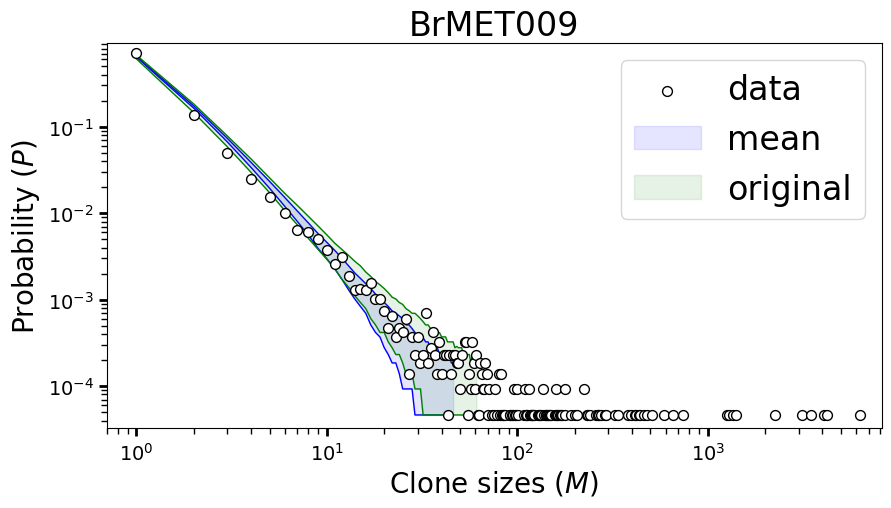

In [21]:
# Load the Excel file and read the contents of the specified sheet
file_path = '/home/gddaslab/mxp140/tcr_project_ultimate/results/results.xlsx'
sheet_name = 'parameters_from_mean_kr_test'
parameters_df = pd.read_excel(file_path, sheet_name=sheet_name)
for patient_id in patients[1:2]:
    # print(f'{patient_id}\n===================')
    patient_data = full_data[full_data["Patient"]==patient_id]
    clone_count_values = patient_data['counts']
    scaled_kr_values = patient_data['kr'].values/max_kr
    mean_kr = np.mean(scaled_kr_values)
    patient_data.loc[:, 'kr'] = mean_kr
    scaled_kr_values = patient_data['kr'].values
    n = len(clone_count_values)
    x1 = 100
    # bounds = ((1e-10, 100),)
    # initial_value = np.random.uniform(bounds[0][0], bounds[0][1], size=1)[0]
    # verbose=True
    # result = run_optimization(clone_count_values, scaled_kr_values, x1, bounds, [initial_value], verbose)
    # x2 = result[1]
    # print(f'x2:{x2}, nll:{result[-1]}')
    # parameters_df.append([patient_id, x1, result[1], initial_value, result[-1]])
    x2 = parameters_df[parameters_df['Patient']==patient_id]['x2'].values[0] #result[1]
    M_max = 10000
    probability_values = probability(x1, x2, mean_kr, list(range(1, M_max+1)))
    size = 1000
    all_configs = np.empty((n, size))
    for i in tqdm.tqdm(range(n), total=n, desc=f'{patient_id}: Generating configuration for each TCR', leave=True):
        config_per_tcr = generate_configuration_per_tcr(probability_values, size=size)
        all_configs[i, :] = config_per_tcr
    # final_configuration = np.concatenate(all_configs)
    fig, ax = plot_pdf(clone_count_values)
    
    ci_df = ci_pdf(all_configs, least_number_of_observations=5)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median'])&(ci_df['lower']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='blue', alpha=0.1, zorder=1, label='mean')
    ax.plot(ci_df['clone_size'], ci_df['lower'], color='blue', alpha=1., linewidth=1., zorder=1)
    ax.plot(ci_df['clone_size'], ci_df['upper'], color='blue', alpha=1., linewidth=1., zorder=1)
    
    with h5py.File(f'{root_dir}/results/probabilities/probs_{patient_id}.h5', 'r') as f:
        probs = f['result'][:]
        # probs = probs[:1000, :100]
        # print(f'{patient_id}:{probs.shape}')
        all_configs = parallel_generate_configuration_per_tcr(probs, size=size)
    ci_df = ci_pdf(all_configs, least_number_of_observations=5)
    ci_df = ci_df[(ci_df['lower']!=ci_df['median'])&(ci_df['lower']!=ci_df['upper'])]
    ax.fill_between(ci_df['clone_size'], ci_df['lower'], ci_df['upper'], color='green', alpha=0.1, zorder=1, label='original')
    ax.plot(ci_df['clone_size'], ci_df['lower'], color='green', alpha=1., linewidth=1., zorder=1)
    ax.plot(ci_df['clone_size'], ci_df['upper'], color='green', alpha=1., linewidth=1., zorder=1)
    
    ax.set_title(f'{patient_id}', fontsize=24)
    ax.legend(loc='best', fontsize=24)
    ax.set_xlabel(r"Clone sizes ($M$)", fontsize=20)
    ax.set_ylabel('Probability ($P$)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=2)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)
    plt.show()